# **Lab 3: Reconstruction from two views (knowing internal camera parameters)**

In this lab you will learn how to estimate the fundamental matrix that relates two images, corresponding to two different views of the same scene, given a set of correspondences between them. Also, you will learn how to triangulate the matching correspondences between two views of the same scene, by means of applying the Direct Linear Method (DLT). Then, you will compute the camera matrices of these images given the Fundamental Matrix and the Intrinsic Matrix, and will evaluate your triangulation method on these camera matrices by estimating the reprojection error in the triangulation. 

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [3]:
from IPython.display import display, HTML
import numpy as np
from numpy import linalg as LA
import cv2
import math
import sys
import random
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (19, 10)
from operator import itemgetter
from plotly import graph_objects as go
import copy
from tqdm import tqdm
from multiprocessing import Pool
import numpy as np
from time import time 
from functools import partial

import utils
from utils import homogeneous2euclidean, euclidean2homogeneous, projective2img, img2projective

np.set_printoptions(precision=3)

## **1. Estimation of the fundamental matrix**

### **1.1 Normalized 8-point algorithm**

The first task is to create the function that estimates the fundamental matrix given a set of point correspondences between a pair of images.

<span style='color:Green'> - Complete the function "fundamental_matrix" below.  </span>

In [4]:
def compute_normalization(points: np.ndarray) -> np.ndarray:
    centroid = np.mean(points, axis=0)
    average_distance = np.mean(np.sqrt(np.sum(np.square(points - centroid), axis=1)))
    scale = np.sqrt(2) / average_distance
    
    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1],
    ])
    
    return T

def create_W_matrix(points1: np.ndarray, points2: np.ndarray) -> np.ndarray:
    u_up = points1[0] * points2[0]
    v_up = points1[1] * points2[0]
    up = points2[0]
    u_vp = points1[0] * points2[1]
    v_vp = points1[1] * points2[1]
    vp = points2[1]
    u = points1[0]
    v = points1[1]
    one = np.ones_like(v)
    
    W = np.column_stack([u_up, v_up, up, u_vp, v_vp, vp, u, v, one])
    
    print("W.shape", W.shape)
    
    return W


def fundamental_matrix(points1, points2):
    points1 = points1 / points1[2, :]
    points2 = points2 / points2[2, :]
    
    T1 = compute_normalization(points1)
    T2 = compute_normalization(points2)
    
    points1_normalized = T1 @ points1
    points2_normalized = T2 @ points2
    
    W = create_W_matrix(points1_normalized, points2_normalized)
    
    # V is returned transposed
    U, D, Vt = np.linalg.svd(W)
    
    # last row because it is transposed
    F_rank3 = Vt[-1, :].reshape((3, 3))
    
    print("V.shape is", Vt.shape)
    print("V is", Vt)
    
    U, D, Vt = np.linalg.svd(F_rank3)
    
    F_rank2 = U @ np.diag(D) @ Vt
    
    print(F_rank2.shape)
    
    
    # TODO: continue
        
    F = T2.T @ F_rank2 @ T1

    
    # TODO: denormalize F
    
    return F

In order to check that the completed function works properly you may use this code which is a toy example where we know the ground truth image.

<span style='color:Green'> - Complete the expression of the ground truth fundamental matrix.  </span>

In [5]:
# Two camera matrices for testing purposes
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1
angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
t = np.array([[.3, .1, .2]])

P2 = np.concatenate((R, t.T), axis=1)
n = 8
rand = np.random.uniform(0,1,n)
rand = rand.reshape((1, n))
rand2 = np.random.uniform(0,1,2*n)
rand2 = rand2.reshape((2, n))
ones = np.ones((1,n))
X = np.concatenate((rand2, 3*rand, ones), axis=0)

x1_test = P1 @ X
x2_test = P2 @ X

# Estimate fundamental matrix (you need to create this function)
F_es = fundamental_matrix(x1_test, x2_test)

# Ground truth fundamental matrix 
skew_matrix_t = np.array([
    [0,  -0.2, 0.1],
    [0.2,  0, -0.3],
    [-0.1, 0.3, 0],
])

F_gt = skew_matrix_t @ R # TODO: complete ...

# Evaluation: these two matrices should be very similar
F_gt = np.sign(F_gt[0,0])*F_gt / LA.norm(F_gt)
F_es = np.sign(F_es[0,0])*F_es / LA.norm(F_es)
print(F_gt)
print(F_es)
print(LA.norm(F_gt-F_es))

W.shape (8, 9)
V.shape is (9, 9)
V is [[ 0.437  0.258 -0.409  0.299  0.195 -0.288 -0.366 -0.238  0.418]
 [-0.333 -0.223  0.12  -0.269 -0.043 -0.049  0.171 -0.178  0.829]
 [ 0.13  -0.131 -0.441 -0.182 -0.498  0.398 -0.276  0.473  0.178]
 [-0.028  0.533  0.13   0.471  0.023  0.36   0.414  0.317  0.272]
 [-0.804  0.342 -0.315  0.063  0.048 -0.093 -0.336  0.015 -0.096]
 [ 0.013  0.236  0.339  0.169 -0.806 -0.278 -0.125 -0.241 -0.009]
 [-0.123 -0.458  0.361  0.56   0.107  0.268 -0.489  0.029  0.086]
 [ 0.094  0.247  0.459 -0.311  0.195 -0.329 -0.353  0.58   0.125]
 [ 0.1    0.374  0.226 -0.374  0.1    0.601 -0.312 -0.437 -0.002]]
(3, 3)
[[ 0.098  0.365 -0.189]
 [-0.365  0.098  0.567]
 [ 0.036 -0.597 -0.   ]]
[[ 9.782e-02  3.651e-01 -1.890e-01]
 [-3.651e-01  9.782e-02  5.669e-01]
 [ 3.581e-02 -5.965e-01 -6.110e-16]]
1.378431956540875e-14


### **1.2 Robust estimation of the fundamental matrix**

The goal of this section is to estimate the fundamental matrix in a practical situation where the image correspondences contain outliers. For that you will have to write the code of the robust version of the previous algorithm.

We will start by computing and visualizing the image matches.

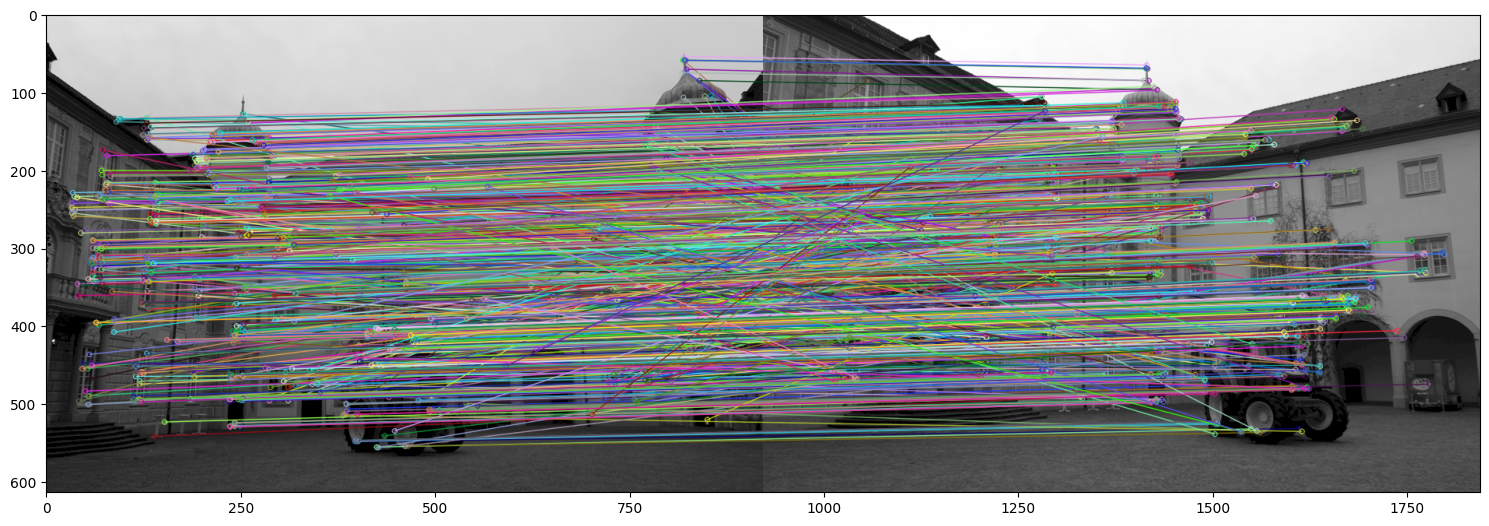

In [6]:
# Compute inage correspondences #

# Read images
img1 = cv2.imread('Data/0000_s.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/0001_s.png',cv2.IMREAD_GRAYSCALE)

# Initiate ORB detector
orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

# Show "good" matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

<span style='color:Green'> - Write the function Ransac_fundamental_matrix that embeds in a RANSAC procedure the previous DLT algorithm for estimating the fundamental matrix. You may use the provided RANSAC function in lab 2 as a starting point.  </span>

Note: In order not to end up, eventually, in an infinite loop, it is recommended to set, at each iteration, the maximum number of iterarions to the maximum between a predefined maximum number of iterations by the user and the automatically estimated max. number of iterarions. The estimated number of iterations ensures we pick, with a probability of 0.99, an initial set of correspondences with no outliers.

In [ ]:
def Ransac_fundamental_matrix(points1, points2, th, max_it_0):
    
    # complete ...
    
    return F, inliers

In [ ]:
# Robust estimation of the fundamental matrix #
points1 = []
points2 = []
for m in matches:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

F, indices_inlier_matches = Ransac_fundamental_matrix(points1, points2, 1, 5000)
inlier_matches = itemgetter(*indices_inlier_matches)(matches)

img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### **1.3 Epipolar lines**

Now the fundamental matrix has been estimated we are going to display some points and their corresponding epipolar lines.

<span style='color:Green'> - Complete the code that computes the epipolar lines in both images.  </span>

In [ ]:
l2 = # epipolar lines in image 2 (complete) 
l1 = # epipolar lines in image 1 (complete) 

# choose three random indices
N = indices_inlier_matches.shape[0]
indices = random.sample(range(1, N), 3)

m1 = indices_inlier_matches[indices[0]]
m2 = indices_inlier_matches[indices[1]]
m3 = indices_inlier_matches[indices[2]]

from PIL import Image, ImageDraw
from utils import line_draw, plot_img

img_path = "./Data/0000_s.png"
I = Image.open(img_path)
size = I.size
canv = ImageDraw.Draw(I)
line_draw(l1[:,m1], canv, size)
line_draw(l1[:,m2], canv, size)
line_draw(l1[:,m3], canv, size)
canv.ellipse((round(points1[0,m1]), round(points1[1,m1]), round(points1[0,m1])+7, round(points1[1,m1])+7), fill = 'red', outline ='red')
canv.ellipse((round(points1[0,m2]), round(points1[1,m2]), round(points1[0,m2])+7, round(points1[1,m2])+7), fill = 'red', outline ='red')
canv.ellipse((round(points1[0,m3]), round(points1[1,m3]), round(points1[0,m3])+7, round(points1[1,m3])+7), fill = 'red', outline ='red')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plot_img(I)

img_path = "./Data/0001_s.png"
I2 = Image.open(img_path)
size = I2.size
canv2 = ImageDraw.Draw(I2)
line_draw(l2[:,m1], canv2, size)
line_draw(l2[:,m2], canv2, size)
line_draw(l2[:,m3], canv2, size)
canv2.ellipse((round(points2[0,m1]), round(points2[1,m1]), round(points2[0,m1])+7, round(points2[1,m1])+7), fill = 'red', outline ='red')
canv2.ellipse((round(points2[0,m2]), round(points2[1,m2]), round(points2[0,m2])+7, round(points2[1,m2])+7), fill = 'red', outline ='red')
canv2.ellipse((round(points2[0,m3]), round(points2[1,m3]), round(points2[0,m3])+7, round(points2[1,m3])+7), fill = 'red', outline ='red')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plot_img(I2)


## **2. Triangulation with the DLT method**

The first task is to implement the DLT method that will compute the 3D points corresponding to the matches of two images whose camera matrices are known. [See derivation of DLT here](https://www.cs.cmu.edu/~16385/s17/Slides/11.4_Triangulation.pdf)

![image](https://user-images.githubusercontent.com/8356912/151347636-c3332917-a7da-402e-9eb6-f39beb91591a.png)


<span style='color:Green'> - Create the function triangulate(x1, x2, P1, P2, imsize) that performs a triangulation with the homogeneous algebraic method (DLT)  </span>

The entries are (x1, x2, P1, P2, imsize), where:
- x1: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 1 reference frame 
- x2: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 2 reference frame.
- P1: Camera 1 matrix of shape (3,4)
- P2: Camera 2 matrix of shape (3,4)
- imsize: Iterable with shape (2,) with the image size

The function should return:
- X: array of shape (4, `n_points`), containing the Homogenous Coordinates of the points in 3D space.  

Test the triangulate function: use this code to validate that the function triangulate works properly

HINT: check numpy.linalg.svd

In [33]:
def image_normalization_matrix(imsize):
    w, h = imsize
    return np.array([
        [2 / w,     0,     -1],
        [0,     2 / h,     -1],
        [0,         0,      1]
    ])

# Write here the method for DLT triangulation
def triangulate(x1, x2, P1, P2, imsize) -> np.ndarray:
    assert P1.shape == (3,4) == P2.shape
    assert x1.shape == x2.shape and x1.shape[0] == 3
    
    T = image_normalization_matrix(imsize)
    P1n = T @ P1
    P2n = T @ P2

    def generate_Ai(x,P):
        x = x / x[2]
        x_1, y_1, _ = x

        Ai = np.vstack([
            y_1 * P[2,:] - P[1,:],
            P[0,:] - x_1 * P[2,:]
        ])
        return Ai
    
    N = x1.shape[1]
    X = np.zeros((4, N), dtype=float)

    for i in range(N):
        # Normalized version
        x1n = T @ x1[:, i]
        x2n = T @ x2[:, i]

        A = np.vstack([
            generate_Ai(x1n, P1n),
            generate_Ai(x2n, P2n)
        ])

        """ 
        # Unormalized version
        A = np.vstack([
            generate_Ai(x1[:, i], P1),
            generate_Ai(x2[:, i], P2)
        ])
        """

        _, _, Vt = np.linalg.svd(A)
        Xi = Vt[-1, :]

        # Normalization for unormalized version
        # Xi = Xi / np.linalg.norm(Xi) 
        
        # Normalization for normalized version
        if abs(Xi[3]) > 1e-12:
            Xi = Xi / Xi[3]

        X[:, i] = Xi
    return X
    

Test the triangulation function with two Cameras and some random points. The average triangulation error should be lower than 10<sup>-8</sup>


In [40]:
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1                            # Cam1 Canonical Camera Matrix

angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])     # Cam2 Rotation_z(theta[deg])
t = np.array([[1.1, .1, .2]])                         # Cam2 Translation(x[m], y[m], z[m]) 
P2 = np.concatenate((R, t.T), axis=1)

n_points = 20                                        # Number of data samples (points) (x,y,z)
X_eucl = np.random.uniform(0, 1, (3,n_points))       # Random points in 3D space on world reference frame
X_eucl[2,:] += 3                                     # Make points fit into the camera frame 
X = euclidean2homogeneous(X_eucl)                    # 

# Obtain the camera coordinates (rays) from each point.
x_proj1 = P1 @ X                                     # Project to Cam1 image coordinates (x,y,z)->[x_c1:y_c1:z_c1]
x_proj2 = P2 @ X                                     # Project to Cam2 image coordinates (x,y,z)->[x_c2:y_c2:z_c2]

# Estimate the 3D points (you need to create this function)
X_trian = triangulate(x_proj1, x_proj2, P1, P2, ((2,2)))
assert X_trian.shape == (4, n_points)

# Evaluation: compute the reprojection error
X_eucl_pred = homogeneous2euclidean(X_trian)
X_eucl = homogeneous2euclidean(X)
errors = np.linalg.norm(X_eucl - X_eucl_pred, axis=0)
avg_error = np.mean(errors)
print(f"Average triangulation error: {avg_error:.2e}[m]")
assert avg_error < 1e-8, "Something might be wrong here"


Average triangulation error: 1.69e-15[m]


 We will plot the results to check that the triangulated values are close to the ground truth

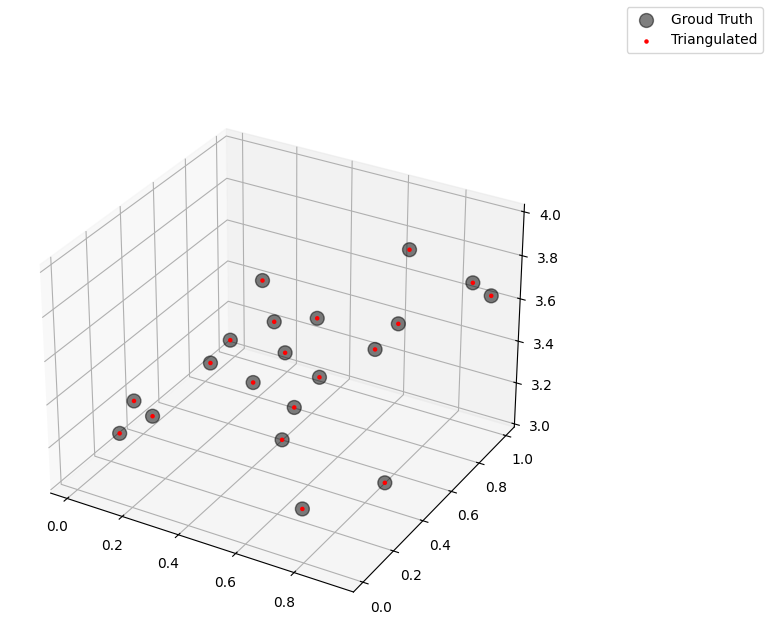

In [21]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
utils.draw_points(X_eucl.T, ax=ax, c="k", alpha=0.5, s=100, depthshade=True, label="Groud Truth")
utils.draw_points(X_eucl_pred.T, ax=ax, c="r", alpha=1, s=5, depthshade=True, label="Triangulated")
fig.legend()

In [22]:
fig = go.Figure(layout=dict(height=400, width=550))
fig.add_trace(go.Scatter3d(x=X_eucl[0,:], y=X_eucl[1,:], z=X_eucl[2,:], mode='markers', marker=dict(size=6, color="black", opacity=0.5), name='Ground Truth'))
fig.add_trace(go.Scatter3d(x=X_eucl_pred[0,:], y=X_eucl_pred[1,:], z=X_eucl_pred[2,:], mode='markers', marker=dict(size=2, color="red", opacity=1), name='Triangulated'))
fig.show()

## **3. Reconstruction from two views**

The goal of this section is to estimate the 3D reconstruction from two views in a practical situation where the image correspondences contain outliers. 

To acomplish this you have to:

1. Find a set of point correspondences between the two images. This correspondences will contain noise/outliers, therefore we cannot use [Epipolar Geometry](https://www.cs.cmu.edu/~16385/s17/Slides/12.1_Epipolar_Geometry.pdf) to calculate the [Essential Matrix](https://www.cs.cmu.edu/~16385/s17/Slides/12.2_Essential_Matrix.pdf), but we can find the Fundamental Matrix. 
2. Estimate the [Fundamental Matrix](https://www.cs.cmu.edu/~16385/s17/Slides/12.3_Fundamental_Matrix.pdf) relating the two camera images. Since correspondances are noisy we will use the [8-point Algorithm](https://www.cs.cmu.edu/~16385/s17/Slides/12.4_8Point_Algorithm.pdf) in combination with the RANSAC algorithm, to find a good estimate of $F$.
3. Calculate the Essential Matrix from the Fundamental Matrix
4. Find the two Camera Matrices.
### **3.1 Estimate the image matches**
(Code is provided)

In [ ]:
# Read images
img1 = cv2.imread('Data/0001_s.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/0002_s.png',cv2.IMREAD_GRAYSCALE)
h, w = img1.shape

# Initiate ORB detector
orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

# Show "good" matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig = plt.figure()
plt.imshow(img_12)
plt.show()

### **3.2 Estimate the Fundamental Matrix**
To find the Fundamental Matrix $F$ we will use the 8-point algorithm. However, using only 8 correspondences might lead to bad estimates of $F$. To find a robust estimate we will use the RANSAC algorithm. In simple words the algorithm samples randomly 8 correspondences and estimates $F_{estimated}$ for these samples, then it evaluates how well does $F_{estimated}$ fit the rest of the data. We repeat this process until a limit of iterations is reached and select the best estimated $F$.  

(Code is provided)

In [ ]:
# Robust estimation of the fundamental matrix #
points1 = []
points2 = []
for m in matches:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

F, indices_inlier_matches = Ransac_fundamental_matrix(points1, points2, 1, 5000)
inlier_matches = itemgetter(*indices_inlier_matches)(matches)

img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig = plt.figure()
plt.imshow(img_12)
plt.show()

### **3.3 Estimate the Essential Matrix**
<span style='color:Green'> - Compute the [Essential matrix](https://www.cs.cmu.edu/~16385/s17/Slides/12.2_Essential_Matrix.pdf) from the Fundamental matrix </span>

In [ ]:
# Camera calibration matrix
K = np.array([[2362.12, 0, 1520.69], [0, 2366.12, 1006.81], [0, 0, 1]])
scale = 0.3;
H = np.array([[scale, 0, 0], [ 0, scale, 0], [0, 0, 1]])
K = H @ K;

def essential_from_fundamental(K, F):
    raise NotImplementedError()

E = essential_from_fundamental(K, F)

### **3.4. Estimate the Camera Matrices from the Essential Matrix (Optional)**
<span style='color:Green'> - Estimate the camera projection matrices. Assuming the first Camera has a cannonical matrix you will obtain four possible Camera Matrices for the second camera, two rotations and two translations.</span>

 - Please explain how do you obtain these estimates, not what algorithm or methodology you used to obtain them. i.e., What system of equations are you solving?
 - Why do you obtain 4 solutions? Why not only one?

HINT: Once you estimate the rotations $R$ and translation $T$ of the second camera matrix, you may get as results improper rotations: $|R| = -1$ i.e., $R \in O(3), R \notin SO(3)$. <span style='color:Green'> (Why do you think this happens?) </span> In that case you should make the rotation proper by avoiding the unwanted reflexion (multiply by -1 so $|R| = 1$): e.g.,
  
      if det(R) < 0:  
          R = -R

In [ ]:
# # camera projection matrix for the first camera
# P1 = ...

# # four possible matrices for the second camera
# Pc2 = [None, None, None, None];
# Pc2[0] = ...
# Pc2[1] = ...
# Pc2[2] = ...
# Pc2[3] = ...

Lets visualize the 4 possible Camera positions and orientations, in relation to Camera 1 

In [ ]:
# plot the first camera and the four possible solutions for the second figure:
fig = plt.figure()
axs = [fig.add_subplot(1,5,i+1, projection='3d') for i in range(5)]
titles = ["Cam 1"] + [r"Cam $2_{%s}$" % int(i+1) for i in range(len(Pc2)) ]

low_lim, up_lim = -1.5, 1.5
for ax, title, P in zip(axs, titles, [P1] + Pc2):
    utils.plot_camera(P,w,h, 1, ax=ax)
    utils.plot_camera(P1,w,h, 1, ax=ax, alpha=0.3, color="k") # Show Cam1 for reference
    ax.set_title(title)
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.set_zlim(low_lim, up_lim)
    
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
for P, color in zip(Pc2, ['r','k','b','g']):
    utils.plot_camera(P,w,h, 1, ax=ax, color=color)
utils.plot_camera(P1,w,h, 1, ax=ax, alpha=0.3, color="k") # Show Cam1 for reference
ax.set_xlim(low_lim, up_lim)
ax.set_ylim(low_lim, up_lim)
ax.set_zlim(low_lim, up_lim)

<span style='color:Green'> - Triangulate the correspondences and select the "optimal" camera, how do you select it ?</span>
   

In [ ]:
img1 = cv2.imread('Data/0000_s.png',cv2.IMREAD_UNCHANGED)


# Obtain the inlier points projective coordinates for Camera 1 and 2 
x1 = ...
x2 = ...

# Prepare figure 
fig = plt.figure(figsize=(15,15))
axs = [fig.add_subplot(2,2,i+1, projection='3d') for i in range(4)]

# Variable for optimal camera
P2_selected = None

low_lim, up_lim = -10, 10
for i, ax, P2 in zip(range(len(Pc2)), axs, Pc2):
    # Estimate by triangulization the 3D coordinates of the matches
    X_pred = triangulate(x1, x2, P1, P2, [w, h])
    X_eucl = homogeneous2euclidean(X_pred)
    
    # Render the 3D point cloud
    x_img = np.transpose(x1[:2]).astype(int)
    rgb_txt = (img1[x_img[:,1], x_img[:,0]])/255
    utils.draw_points(X_eucl.T, color=rgb_txt, ax=ax)
    utils.plot_camera(P1,w,h,1, ax=ax)
    utils.plot_camera(P2,w,h,1, ax=ax)
    ax.set_title(r"Cam $2_{%d}$" % (i+1))
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.set_zlim(low_lim, up_lim)
    
    # Select the best camera using some metric 
    some_metric = True:
    if some_metric:
        P2_selected = P2

# From now own P2 will be the camera you selected
P2 = P2_selected

### **3.5 3D Visualization (Optiona, provided)**
 We will visualize the 3D points for the selected camera with an interactive plot so that you can see the surfaces reconstructed in 3D

In [ ]:
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()


In [ ]:
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()
#### And these are the corresponding points in 2D 

In [ ]:
img_with_selected_points = copy.deepcopy(img1)
img_with_selected_points[x_img[:,1], x_img[:,0]] = [255,0,0]
plt.figure(figsize = (80,40))
plt.imshow(img_with_selected_points)

### **3.6 Reprojection Error (Optional)**

Once you selected a Camera, analyze the error of reprojecting the 3D space back to image coordinates. 

<span style='color:Green'>- Compute the reprojection errors  </span>

<span style='color:Green'>- Plot the histogram of reprojection errors, </span>

<span style='color:Green'>- Plot the mean reprojection error  </span>

In [ ]:
def reprojection_errors(x1, x2, P1, P2, X):
    """
    - x1: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 1 reference frame 
    - x2: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 2 reference frame.
    - P1: Camera 1 matrix
    - P2: Camera 2 matrix 
    - X: (4, `n_points`) homogenous coordinates of points in 3D space
    Compute the reprojection error from `X` to each of the camera's projective coordinates
    @return: (cam1_errors, cam2_errors)
    """
    
    '''
    Your implementation here
    '''
    raise NotImplementedError("You must implement this, don't forget")

    return cam1_errors, cam2_errors

def plot_error_stats(cam1_errors, cam2_errors):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    
    ax1.hist(cam1_errors, color='c')
    ax1.grid(axis='y', alpha=0.2)
    ax1.set_xlabel("Reprojection Error Cam 1 [What units am I?]")
    ax2.hist(cam2_errors, color='k')
    ax2.grid(axis='y', alpha=0.2)
    ax2.set_xlabel("Reprojection Error Cam 2 [What units am I?]")


# Get projections with selected Camera 
X_pred = ...

cam1_errors, cam2_errors = reprojection_errors(x1, x2, P1, P2, X_pred)

plot_error_stats(cam1_errors, cam2_errors)